# 06. Time series data - Version: monthly data analysis
## Notebook content:

#### PART 1: Analysing time series data
    1. Importing libraries and data
    2. Subsetting, wrangling, and cleaning time-series data
    3. Time series analysis: decomposition
    4. Testing for stationarity
    5. Stationarizing the data
    
#### PART 2: Time series forecasting
    1. Defining parameters
    2. Splitting data
    3. Running and fitting the model
    4. Iterating

## PART 1: Analysing time series data

### 1. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how the plots will appear.

In [2]:
path = r'C:\Users\bruna\Data Analysis Projects\2023-12 Superstore Sales Analysis'

In [3]:
# Import the sales data
sales_clean = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'sales_clean.pkl'))

In [4]:
sales_clean.head()

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Segment,City,State,Postal_Code,Region,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.960,2,0.0,41.9136
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Corporate,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.2,2.5164
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Consumer,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.860,7,0.0,14.1694
6,7,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Consumer,Los Angeles,California,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.280,4,0.0,1.9656


In [5]:
sales_clean.shape

(8113, 19)

### 2. Subsetting and smoothing time-series data

In [83]:
# Group by 'Order_Date' (month) and sum the 'Sales' values
sales_per_month = sales_clean.groupby(sales_clean['Order_Date'].dt.to_period('M'))['Sales'].sum().reset_index()

# Rename columns for clarity
sales_per_month.columns = ['Order_Month', 'Monthly_Sales']

In [84]:
sales_per_month.head()

,Order_Month,Monthly_Sales
0,2014-01,4710.951
1,2014-02,2320.352
2,2014-03,13600.285
3,2014-04,10134.491
4,2014-05,7887.847


In [85]:
sales_per_month.shape

(48, 2)

In [86]:
# Check for missing values

sales_per_month.isnull().sum() 

Order_Month      0
Monthly_Sales    0
dtype: int64

In [87]:
# Check for duplicates

dups = sales_per_month.duplicated()
dups.sum()

#No dups

0

In [88]:
# Set the "Date" column as the index

from datetime import datetime

sales_per_month['datetime'] = sales_per_month['Order_Month'].dt.to_timestamp()
sales_per_month = sales_per_month.set_index('datetime') # Set the datetime as the index of the dataframe.
sales_per_month.drop(['Order_Month'], axis=1, inplace=True) # Drop the "Order_Date" column.
sales_per_month.head()

,Monthly_Sales
datetime,
2014-01-01,4710.951
2014-02-01,2320.352
2014-03-01,13600.285
2014-04-01,10134.491
2014-05-01,7887.847


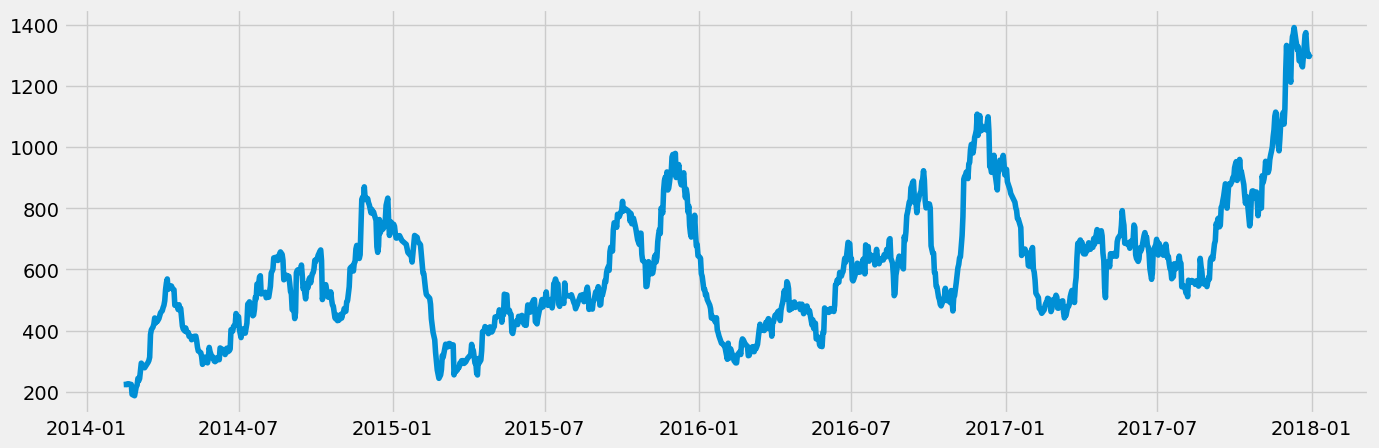

In [89]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(sales_per_date)

### 3. Time-series analysis: decomposition

In [90]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(sales_per_month, model='additive', period = 1)

In [91]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

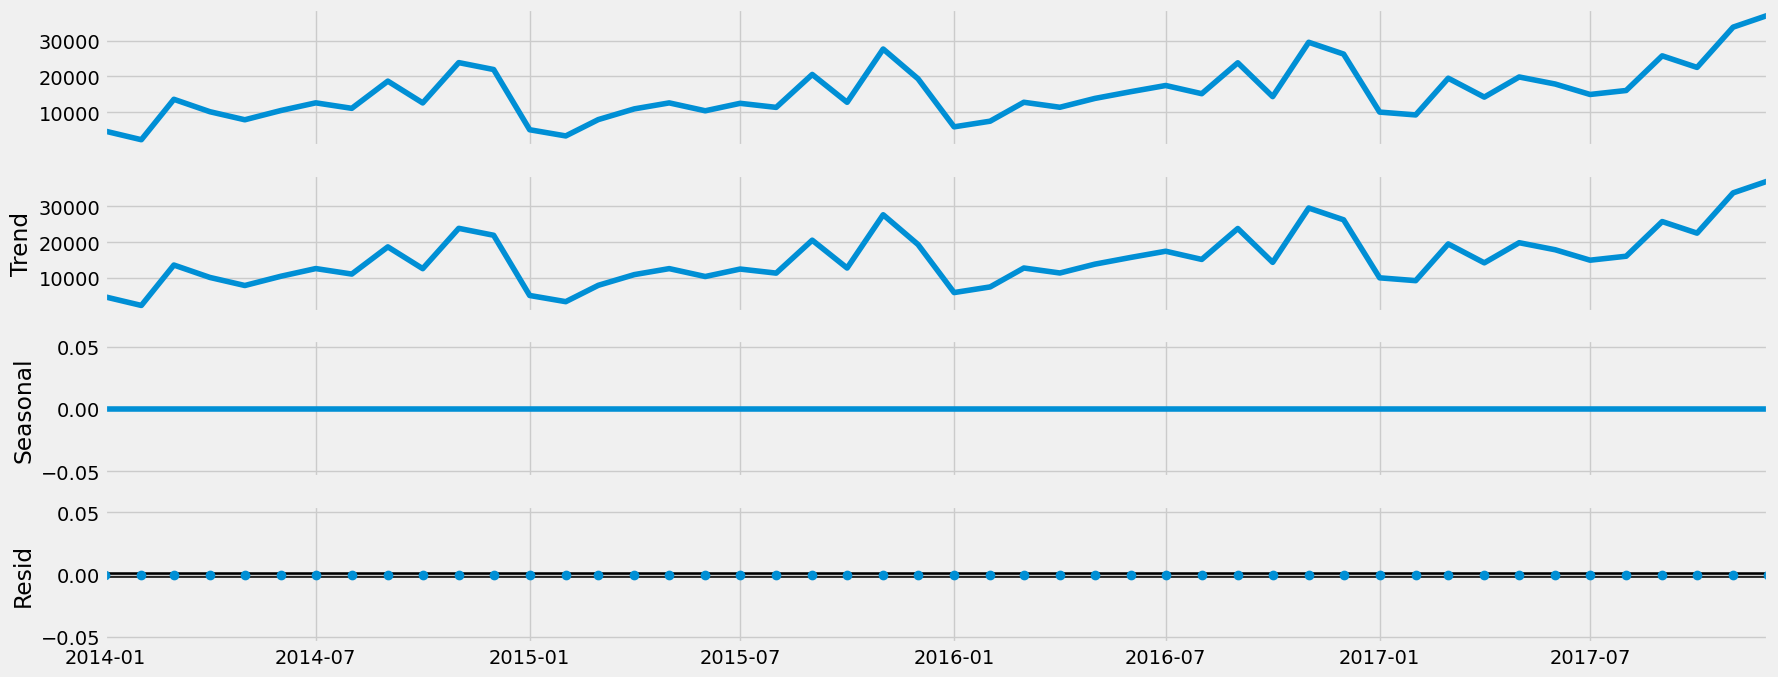

In [92]:
# Plot the separate components

decomposition.plot()
plt.show()

- Conclusions: 
There is no seasonality in the data, and the noise has been removed during Smoothing process.
The data seems to have a slight positive trend, indicating it might notbe starionary. Testing for stationarity is crucial.

### 4. Testing for stationarity

In [93]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why we need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(sales_per_month['Monthly_Sales'])

Dickey-Fuller Stationarity test:
Test Statistic                 -3.275396
p-value                         0.016015
Number of Lags Used             0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


- Conclusion: 
p-value is <0.05 indicating a significant result. 
Test statistic is smaller than the critical value (5%), which means the null hypothesis can be rejected. There isn't a unit root in the data, indicating the data is stationary. An auto-correlation check is needed to confirm non-stationarity


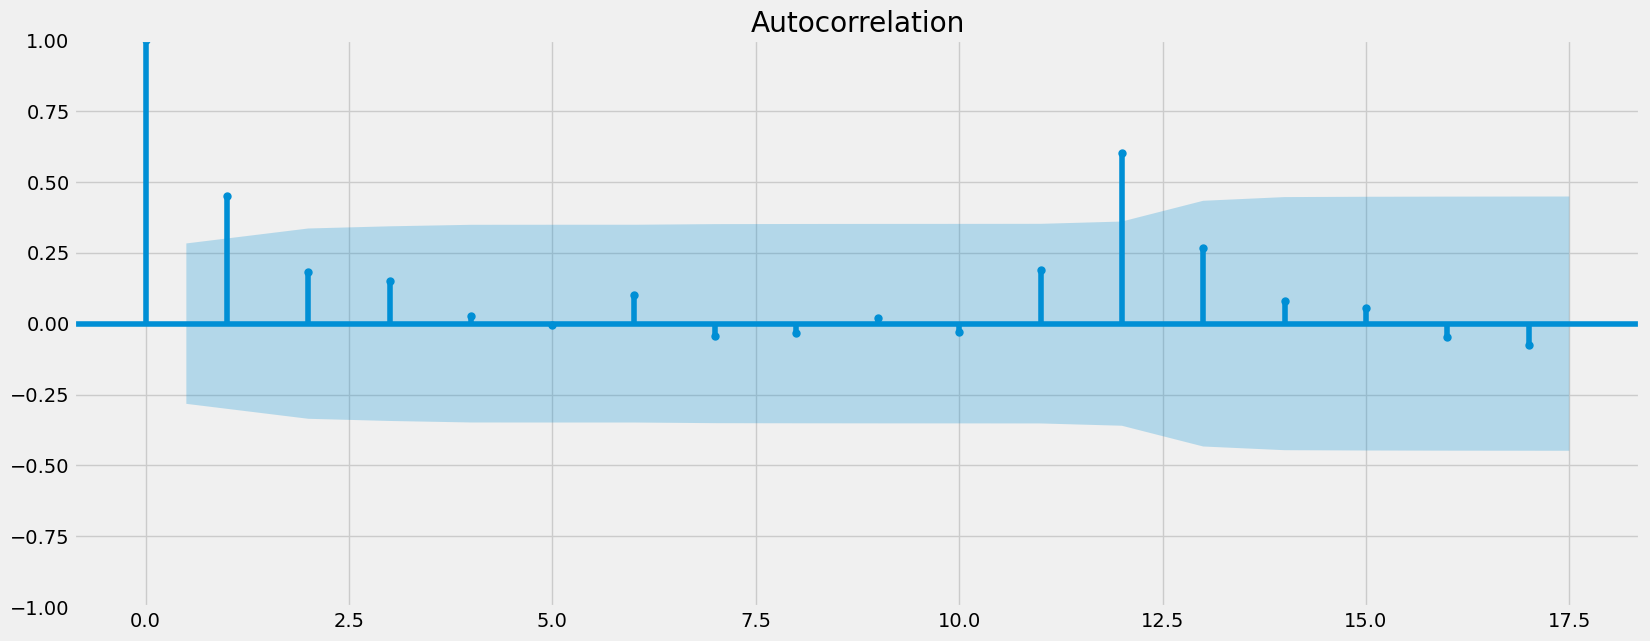

In [94]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(sales_per_month)
plt.show()

- Conclusion: there are very few vertical lines above the confidence interval, confirming the data is stationary.

## PART 2: Time series forecasting

### 1. Defining Your Parameters

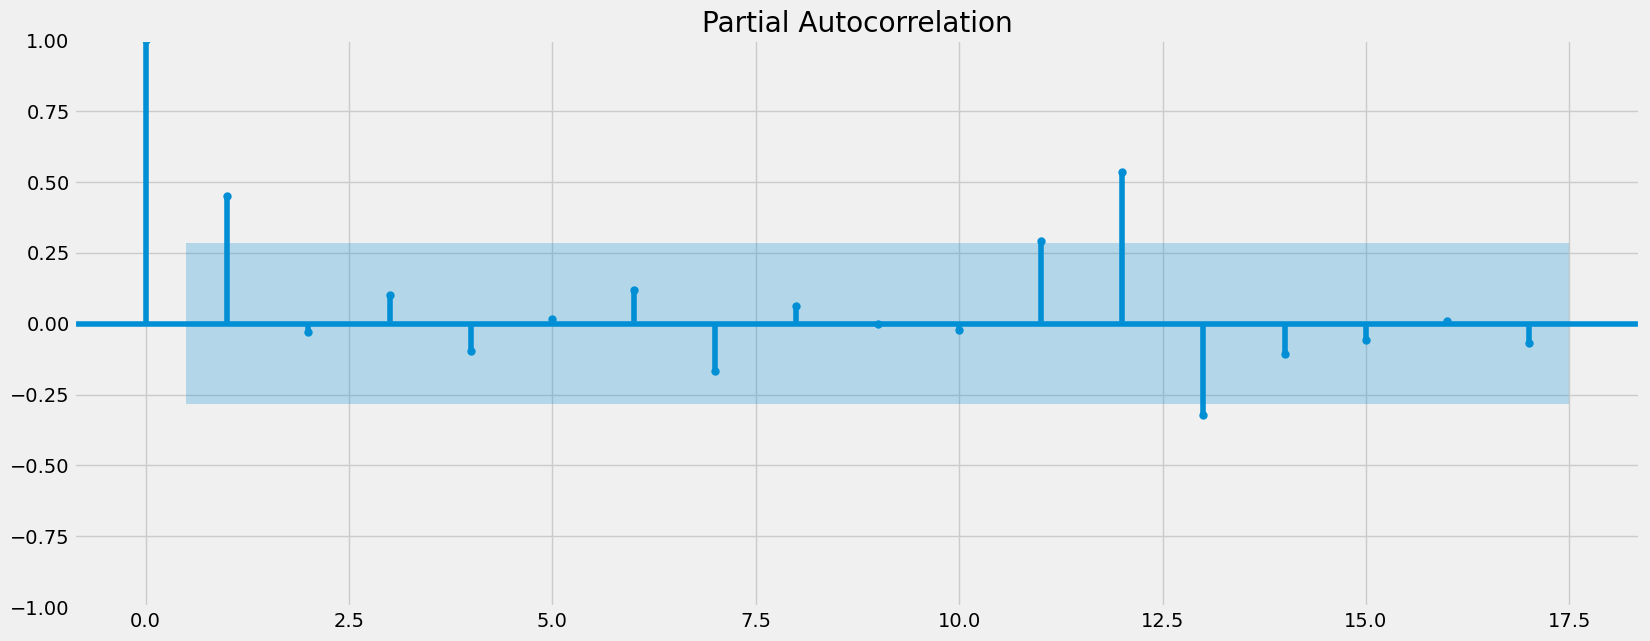

<Figure size 4500x4500 with 0 Axes>

In [95]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(sales_per_month)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

There are some highly positive bars. These indicate significant correlations. Let’s start by picking 5 AR terms to compensate for the highest of the partial autocorrelations. This makes p = 5.

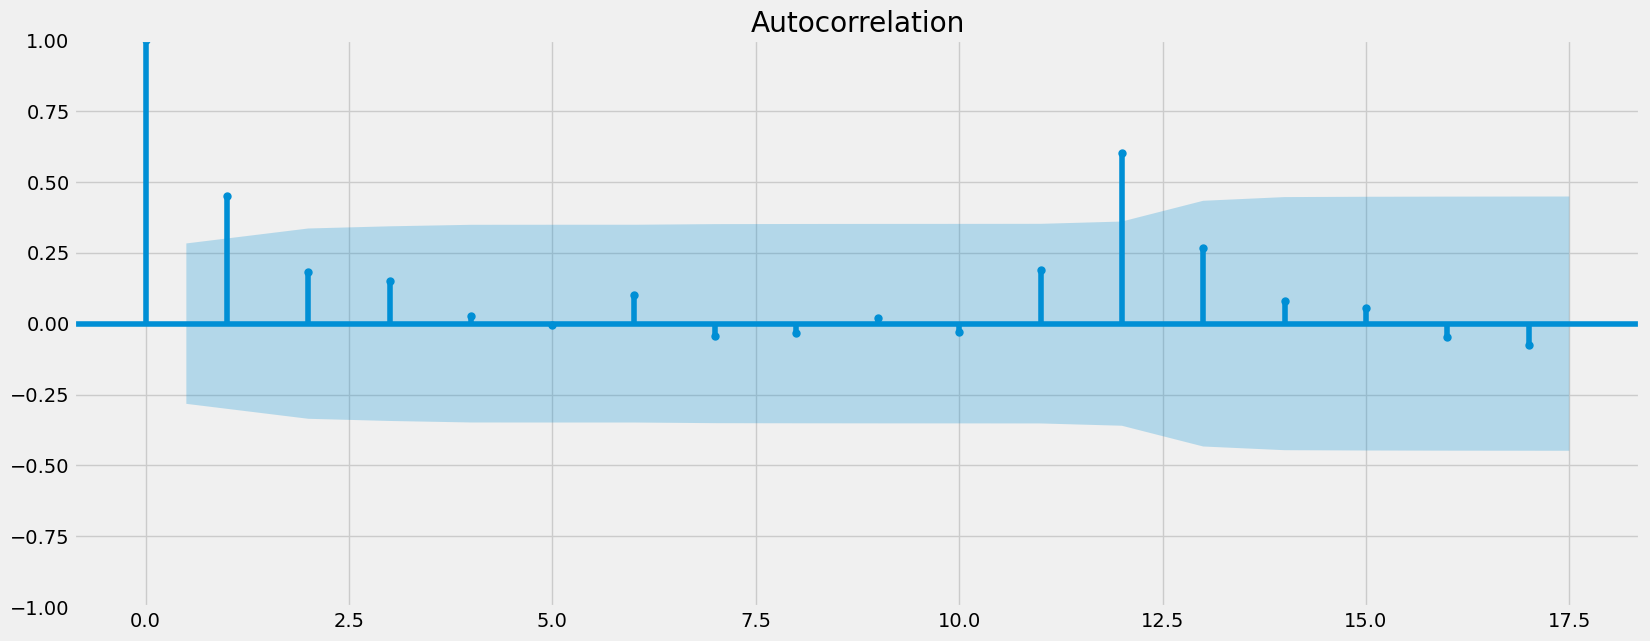

<Figure size 1500x500 with 0 Axes>

In [96]:
# Plot autocorrelations to determine parameter q

plot_acf(sales_per_month)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

q = 3

### 2. Splitting the Data

In [103]:
# Split the data

train = sales_per_month['Monthly_Sales'][:31]
test = sales_per_month['Monthly_Sales'][30:]

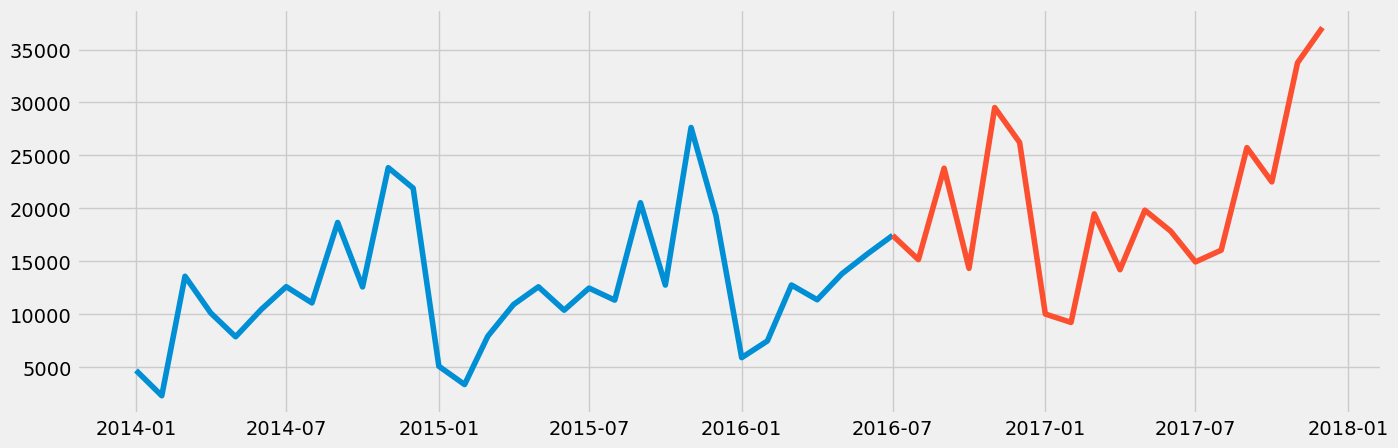

In [104]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [105]:
test.shape

(18,)

### 3. Running and Fitting the Model

In [45]:
from statsmodels.tsa.api import ARIMA # Import the model you need

                               SARIMAX Results                                
Dep. Variable:          Monthly_Sales   No. Observations:                   31
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -301.817
Date:                Sun, 21 Jan 2024   AIC                            621.635
Time:                        17:10:40   BIC                            634.246
Sample:                    01-01-2014   HQIC                           625.669
                         - 07-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2911      0.629     -2.051      0.040      -2.525      -0.058
ar.L2         -0.1298      1.088     -0.119      0.905      -2.263       2.003
ar.L3          0.1673      0.991      0.169      0.8

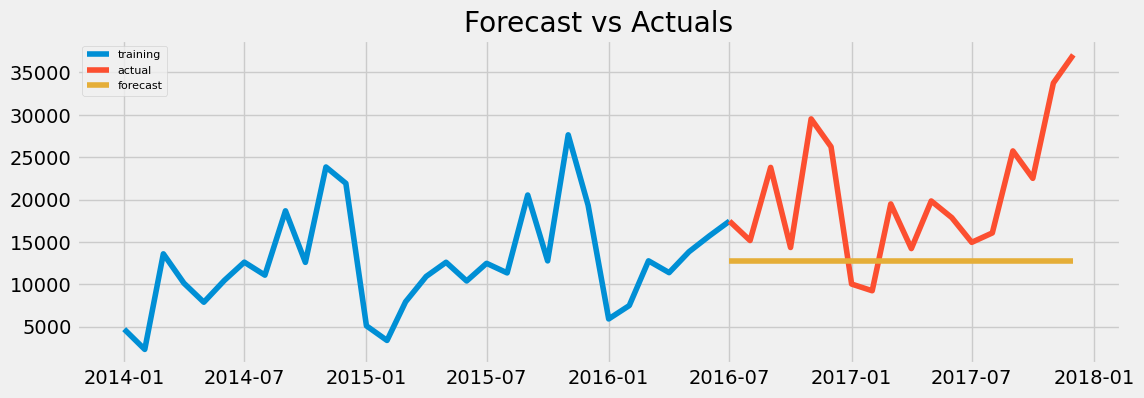

In [116]:
model = ARIMA(train, order=(5, 1, 3))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
fc, se, conf = fitted.forecast(3, 18, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05

# Make into pandas series
fc_series = pd.Series(fc, index=test.index) # This creates the forecasted curve

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 4. Iterating

                               SARIMAX Results                                
Dep. Variable:          Monthly_Sales   No. Observations:                   31
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -303.834
Date:                Sun, 21 Jan 2024   AIC                            617.669
Time:                        17:12:23   BIC                            624.675
Sample:                    01-01-2014   HQIC                           619.910
                         - 07-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3824      0.596      0.642      0.521      -0.786       1.550
ar.L2         -0.0144      0.436     -0.033      0.974      -0.869       0.840
ar.L3         -0.0559      0.461     -0.121      0.9

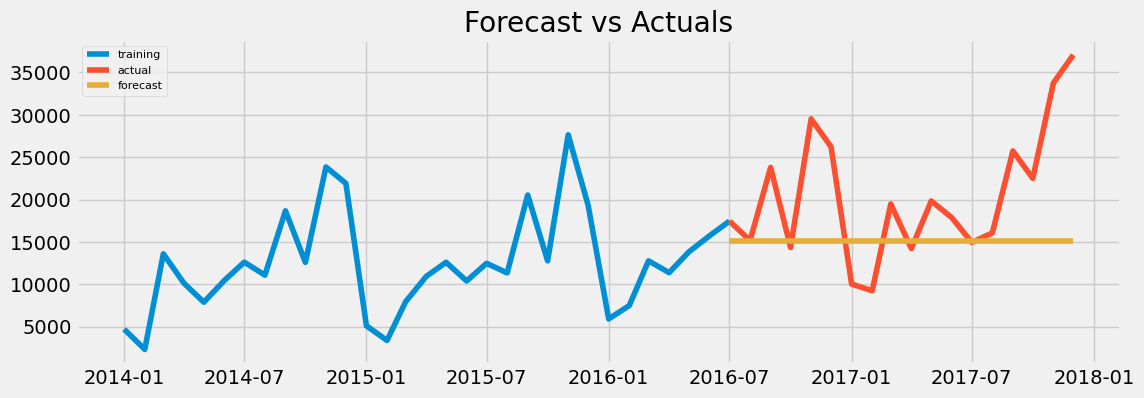

In [121]:
model = ARIMA(train, order=(3, 1, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(3, 18, alpha=0.05)  # 95% conf

# Make into pandas series
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                               SARIMAX Results                                
Dep. Variable:          Monthly_Sales   No. Observations:                   31
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -303.925
Date:                Sun, 21 Jan 2024   AIC                            615.849
Time:                        17:12:42   BIC                            621.454
Sample:                    01-01-2014   HQIC                           617.642
                         - 07-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3420      1.415      0.242      0.809      -2.431       3.115
ma.L1         -0.8438      1.463     -0.577      0.564      -3.712       2.024
ma.L2         -0.0484      0.930     -0.052      0.9

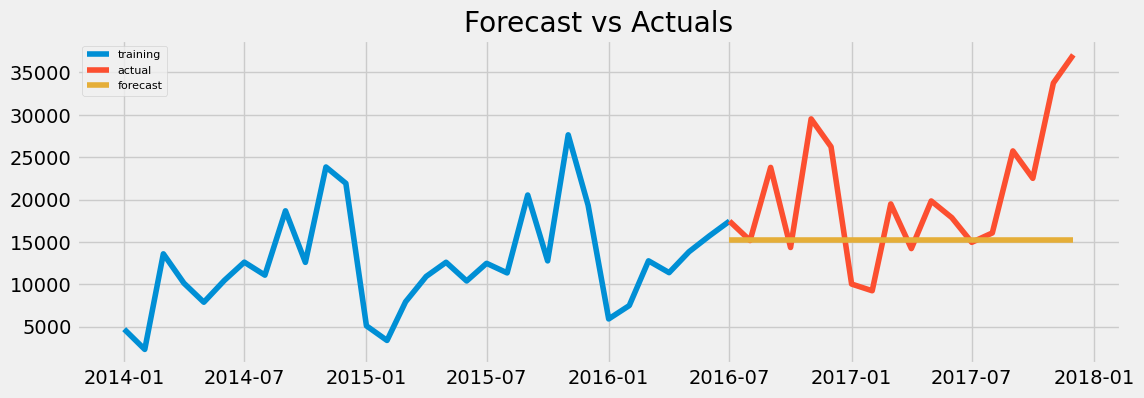

In [122]:
model = ARIMA(train, order=(1, 1, 2))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(3, 18, alpha=0.05)  # 95% conf

# Make into pandas series
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()